In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc, precision_recall_curve)

import shap
import lime
import lime.lime_tabular

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

In [2]:
# Load data
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

print("Data Shape:", df.shape)
print("\nFirst few rows of data:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nTarget Variable Distribution:")
attrition_counts = df['Attrition'].value_counts()
print(attrition_counts)
print(f"Attrition Rate: {attrition_counts['Yes'] / len(df) * 100:.2f}%")

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

print("\nColumns with missing values:")
print(missing_df)

Data Shape: (1470, 35)

First few rows of data:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisf

In [3]:
#preprocessing
data = df.copy()

data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')

numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'Attrition' in numerical_cols:
    numerical_cols.remove('Attrition')

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

print("Categorical variables encoded.")

constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print(f"Constant columns: {constant_columns}")

if constant_columns:
    data = data.drop(columns=constant_columns)
    print(f"Removed constant columns: {constant_columns}")

X = data.drop('Attrition', axis=1)
y = data['Attrition']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Categorical columns: 8
Numerical columns: 26
Categorical variables encoded.
Constant columns: ['EmployeeCount', 'Over18', 'StandardHours']
Removed constant columns: ['EmployeeCount', 'Over18', 'StandardHours']
Features shape: (1470, 31)
Target shape: (1470,)


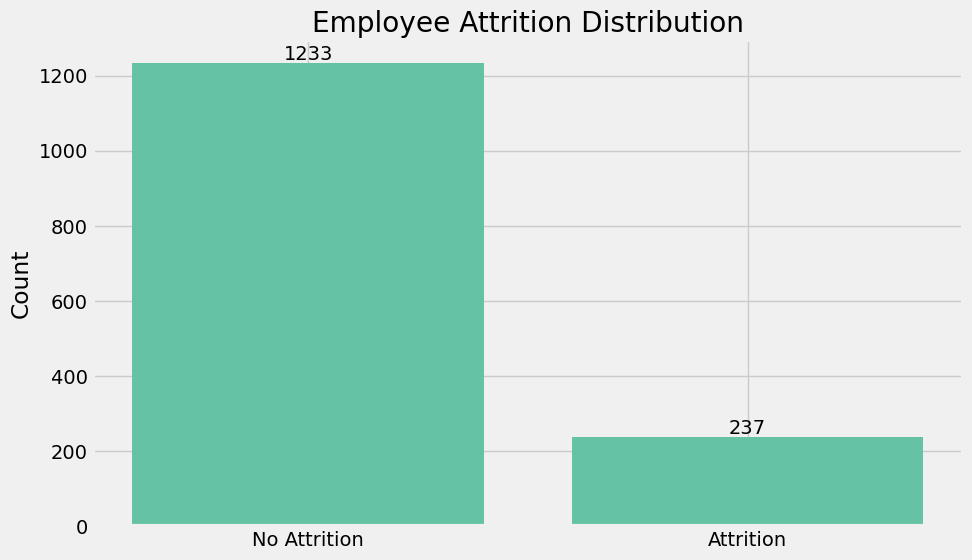

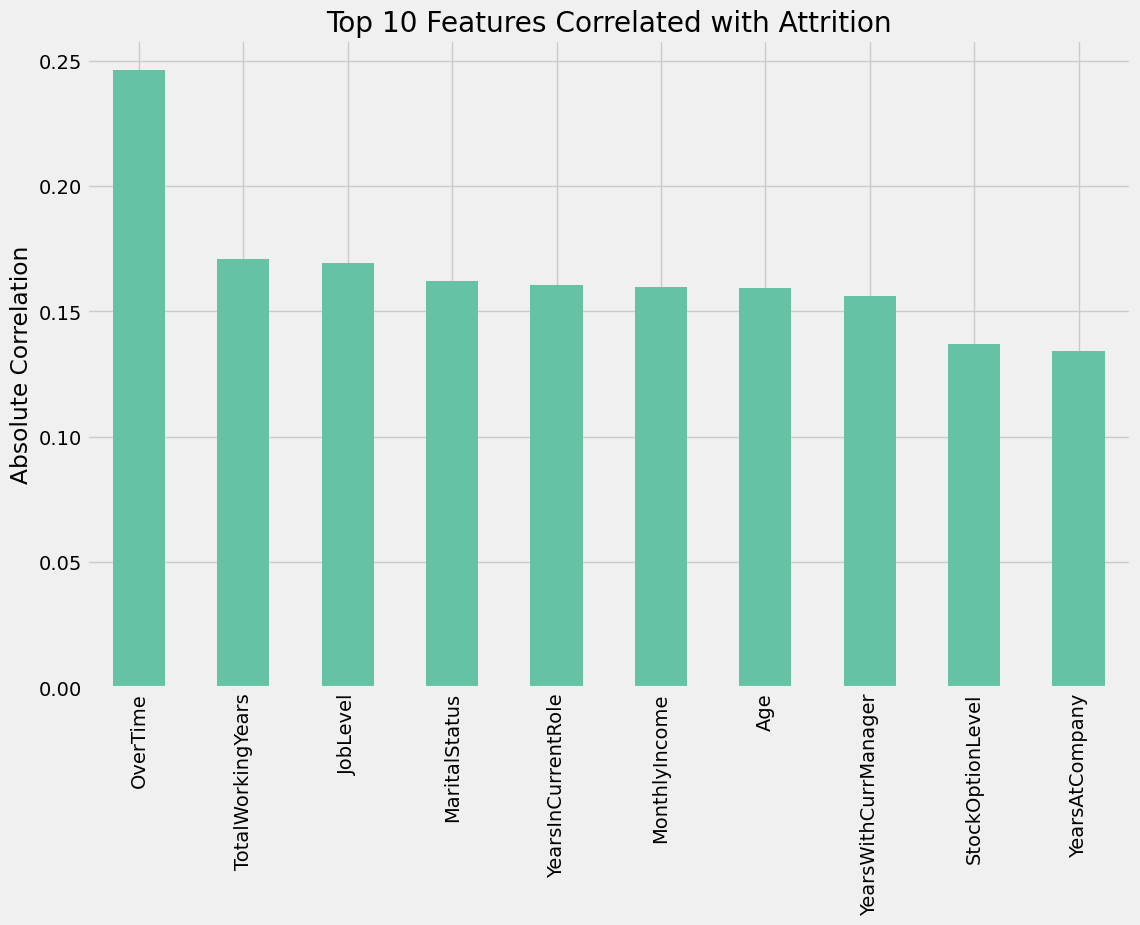

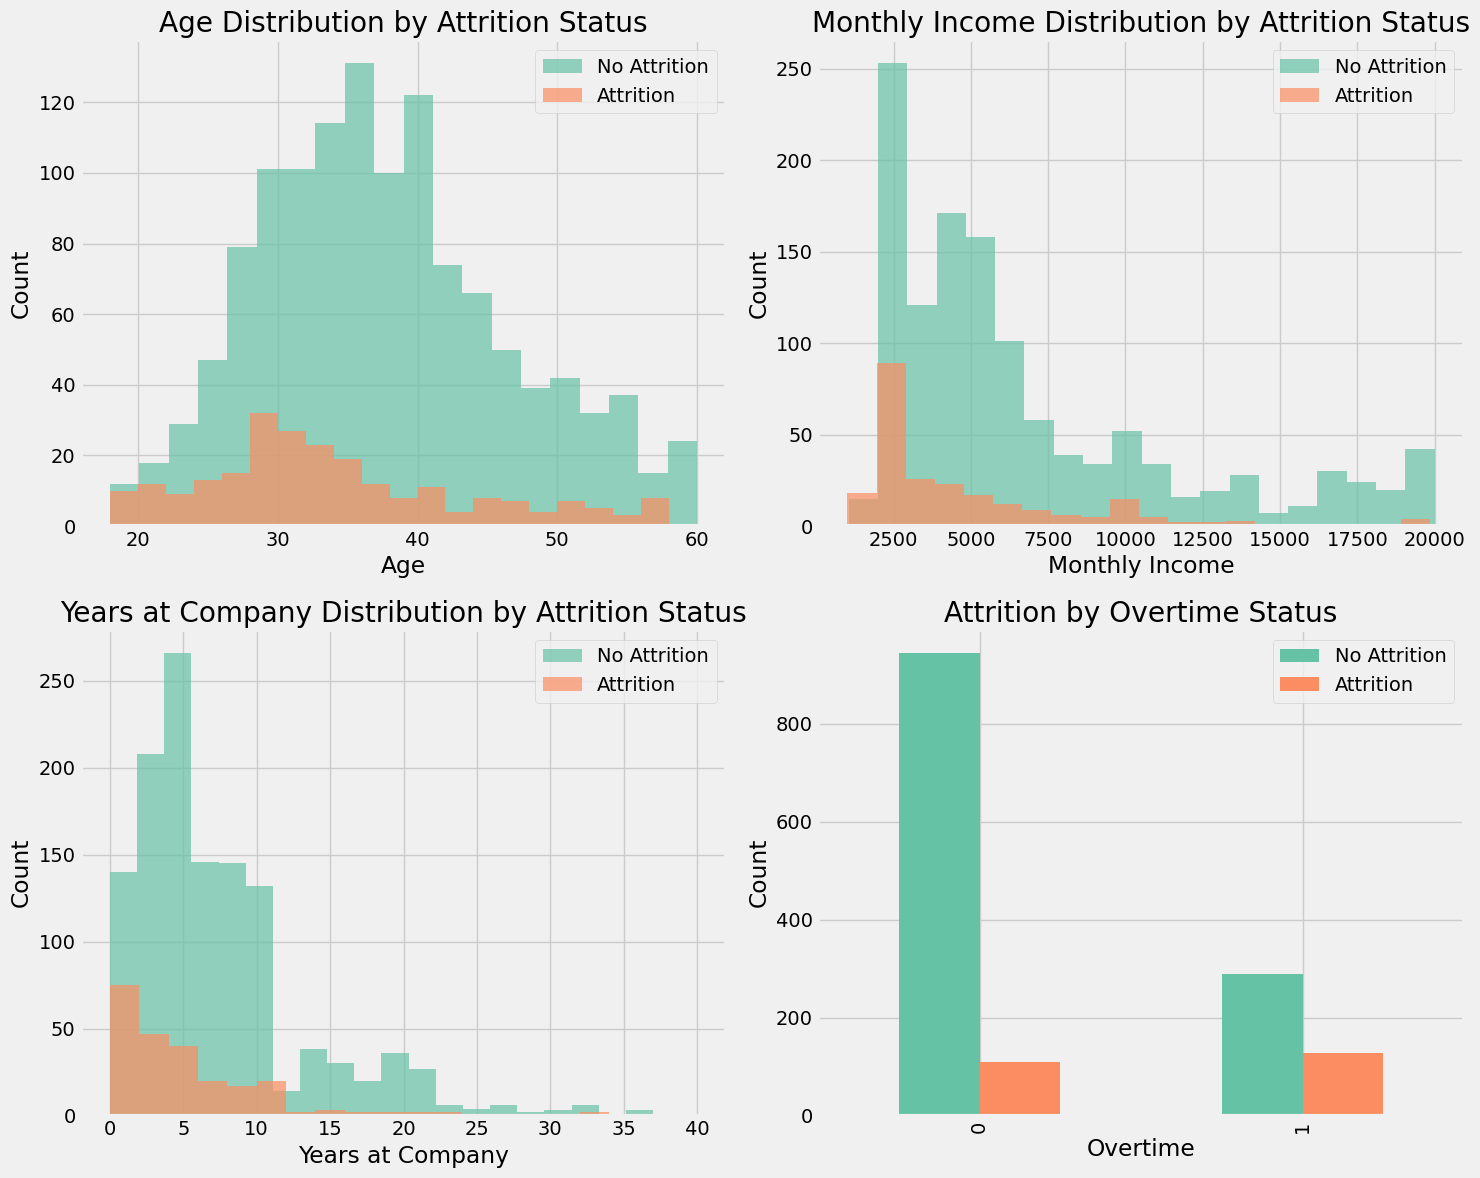

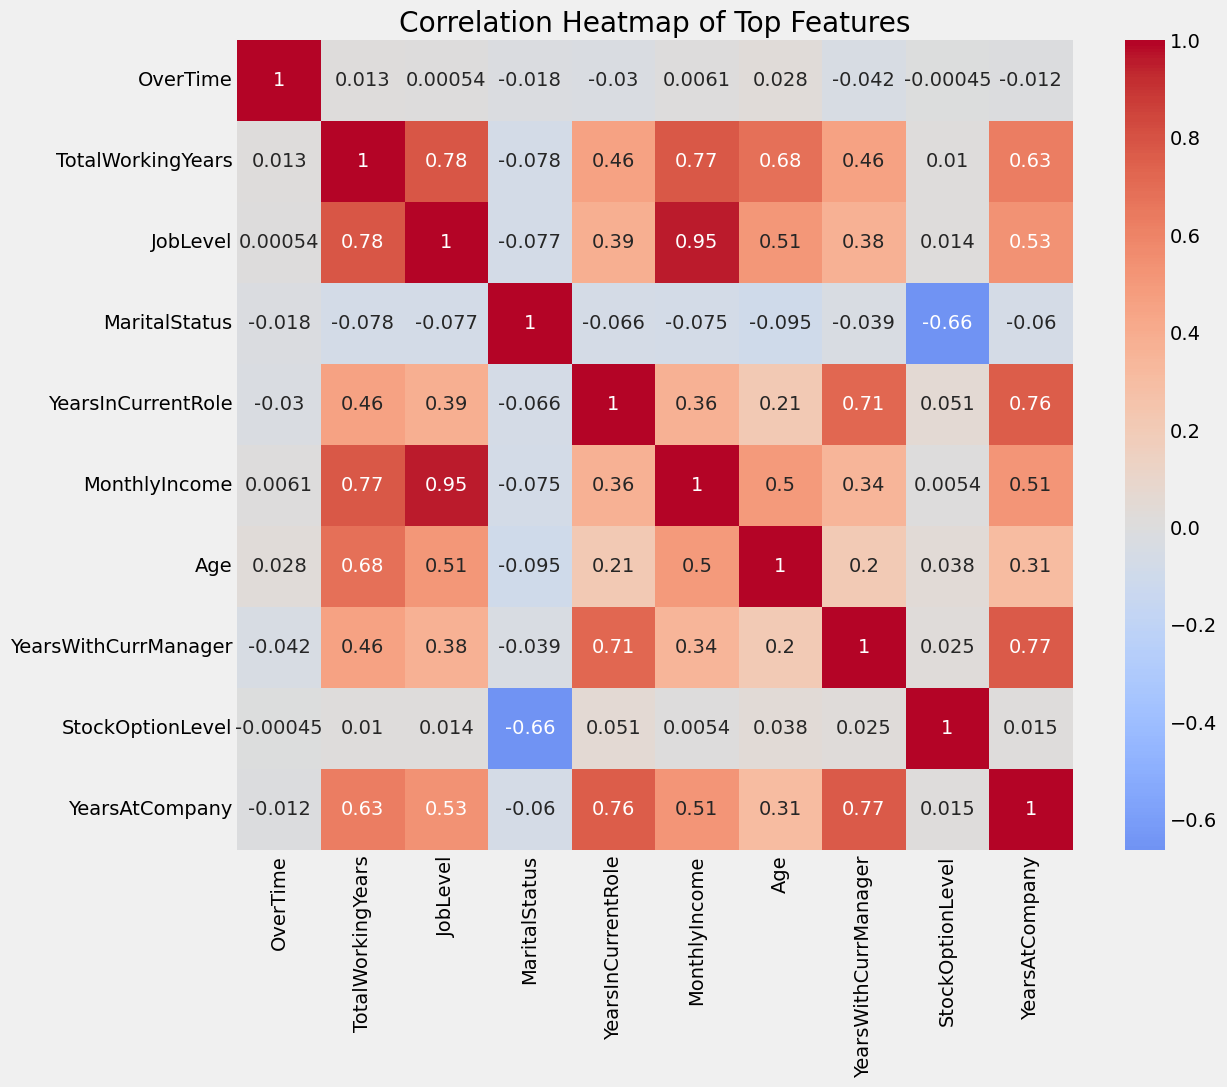

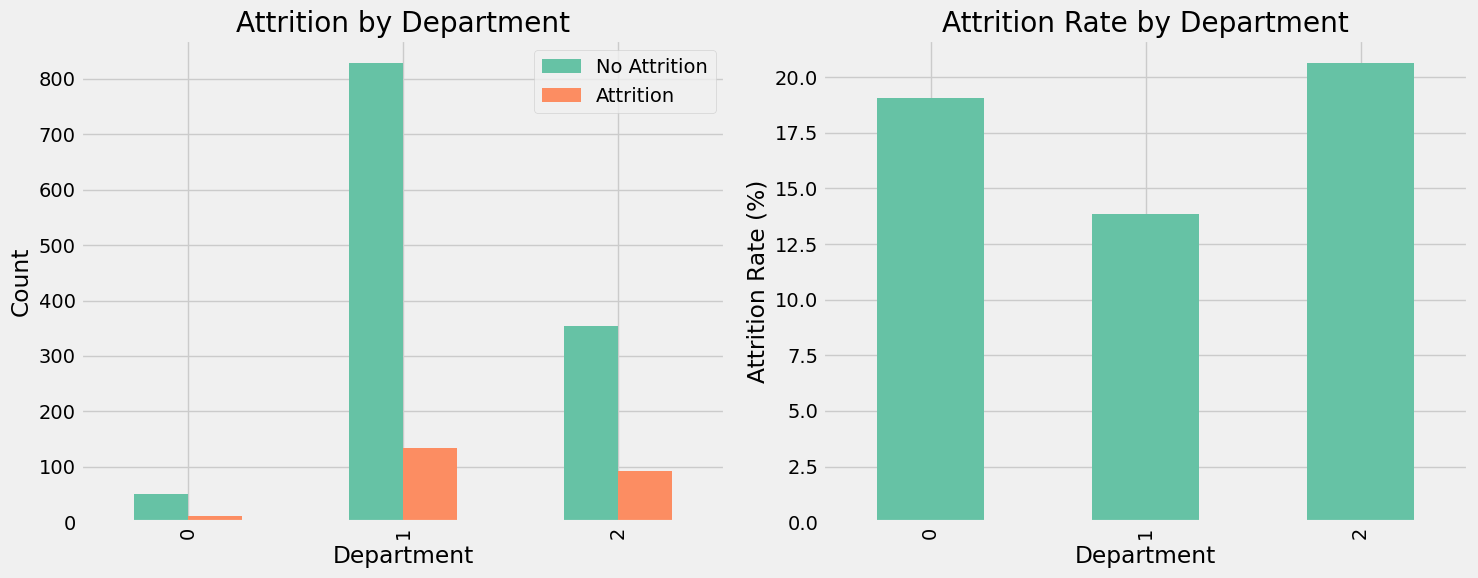

In [5]:
# Target distribution
plt.figure(figsize=(10, 6))
attrition_counts = y.value_counts()
plt.bar(['No Attrition', 'Attrition'], attrition_counts.values)
plt.title('Employee Attrition Distribution')
plt.ylabel('Count')
for i, v in enumerate(attrition_counts.values):
    plt.text(i, v + 10, str(v), ha='center')
plt.show()

# Correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
top_correlations = correlations.head(10)

plt.figure(figsize=(12, 8))
top_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Attrition')
plt.ylabel('Absolute Correlation')
plt.show()

# Distribution of important features by attrition
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age
axes[0, 0].hist(X[y == 0]['Age'], bins=20, alpha=0.7, label='No Attrition')
axes[0, 0].hist(X[y == 1]['Age'], bins=20, alpha=0.7, label='Attrition')
axes[0, 0].set_title('Age Distribution by Attrition Status')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

# Monthly Income
axes[0, 1].hist(X[y == 0]['MonthlyIncome'], bins=20, alpha=0.7, label='No Attrition')
axes[0, 1].hist(X[y == 1]['MonthlyIncome'], bins=20, alpha=0.7, label='Attrition')
axes[0, 1].set_title('Monthly Income Distribution by Attrition Status')
axes[0, 1].set_xlabel('Monthly Income')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

# Years at Company
axes[1, 0].hist(X[y == 0]['YearsAtCompany'], bins=20, alpha=0.7, label='No Attrition')
axes[1, 0].hist(X[y == 1]['YearsAtCompany'], bins=20, alpha=0.7, label='Attrition')
axes[1, 0].set_title('Years at Company Distribution by Attrition Status')
axes[1, 0].set_xlabel('Years at Company')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# Overtime
overtime_attrition = pd.crosstab(data['OverTime'], y)
overtime_attrition.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Attrition by Overtime Status')
axes[1, 1].set_xlabel('Overtime')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['No Attrition', 'Attrition'])

plt.tight_layout()
plt.show()

# Correlation heatmap of top features
top_features = top_correlations.index.tolist()[:10]

plt.figure(figsize=(12, 10))
corr_matrix = X[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top Features')
plt.show()

# Department-wise attrition
if 'Department' in X.columns:
    dept_attrition = pd.crosstab(data['Department'], y)
    dept_attrition_percentage = dept_attrition.div(dept_attrition.sum(axis=1), axis=0) * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    dept_attrition.plot(kind='bar', ax=ax1)
    ax1.set_title('Attrition by Department')
    ax1.set_xlabel('Department')
    ax1.set_ylabel('Count')
    ax1.legend(['No Attrition', 'Attrition'])
    
    dept_attrition_percentage[1].plot(kind='bar', ax=ax2)
    ax2.set_title('Attrition Rate by Department')
    ax2.set_xlabel('Department')
    ax2.set_ylabel('Attrition Rate (%)')
    
    plt.tight_layout()
    plt.show()

In [6]:
print(f"Class distribution: {y.value_counts()}")
print(f"Attrition rate: {y.mean():.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final, y_train_final = X_train_scaled, y_train

Class distribution: Attrition
0    1233
1     237
Name: count, dtype: int64
Attrition rate: 0.1612
Train shape: (1176, 31), Test shape: (294, 31)


In [7]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=(len(y_train_final) - sum(y_train_final)) / sum(y_train_final)),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train_final, y_train_final)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results]
})

print("\nModel Performance Comparison:")
print(comparison_df)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.7551, Precision: 0.3711, Recall: 0.7660, F1: 0.5000, ROC-AUC: 0.8029
--------------------------------------------------
Training Random Forest...
Random Forest - Accuracy: 0.8367, Precision: 0.4286, Recall: 0.0638, F1: 0.1111, ROC-AUC: 0.7615
--------------------------------------------------
Training XGBoost...
XGBoost - Accuracy: 0.8401, Precision: 0.5000, Recall: 0.3191, F1: 0.3896, ROC-AUC: 0.7846
--------------------------------------------------
Training CatBoost...
CatBoost - Accuracy: 0.8537, Precision: 0.5500, Recall: 0.4681, F1: 0.5057, ROC-AUC: 0.8022
--------------------------------------------------

Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.755102   0.371134  0.765957  0.500000  0.802912
1        Random Forest  0.836735   0.428571  0.063830  0.111111  0.761521
2              XGBoost  0.840136   0.500000  0.319149  0.3896

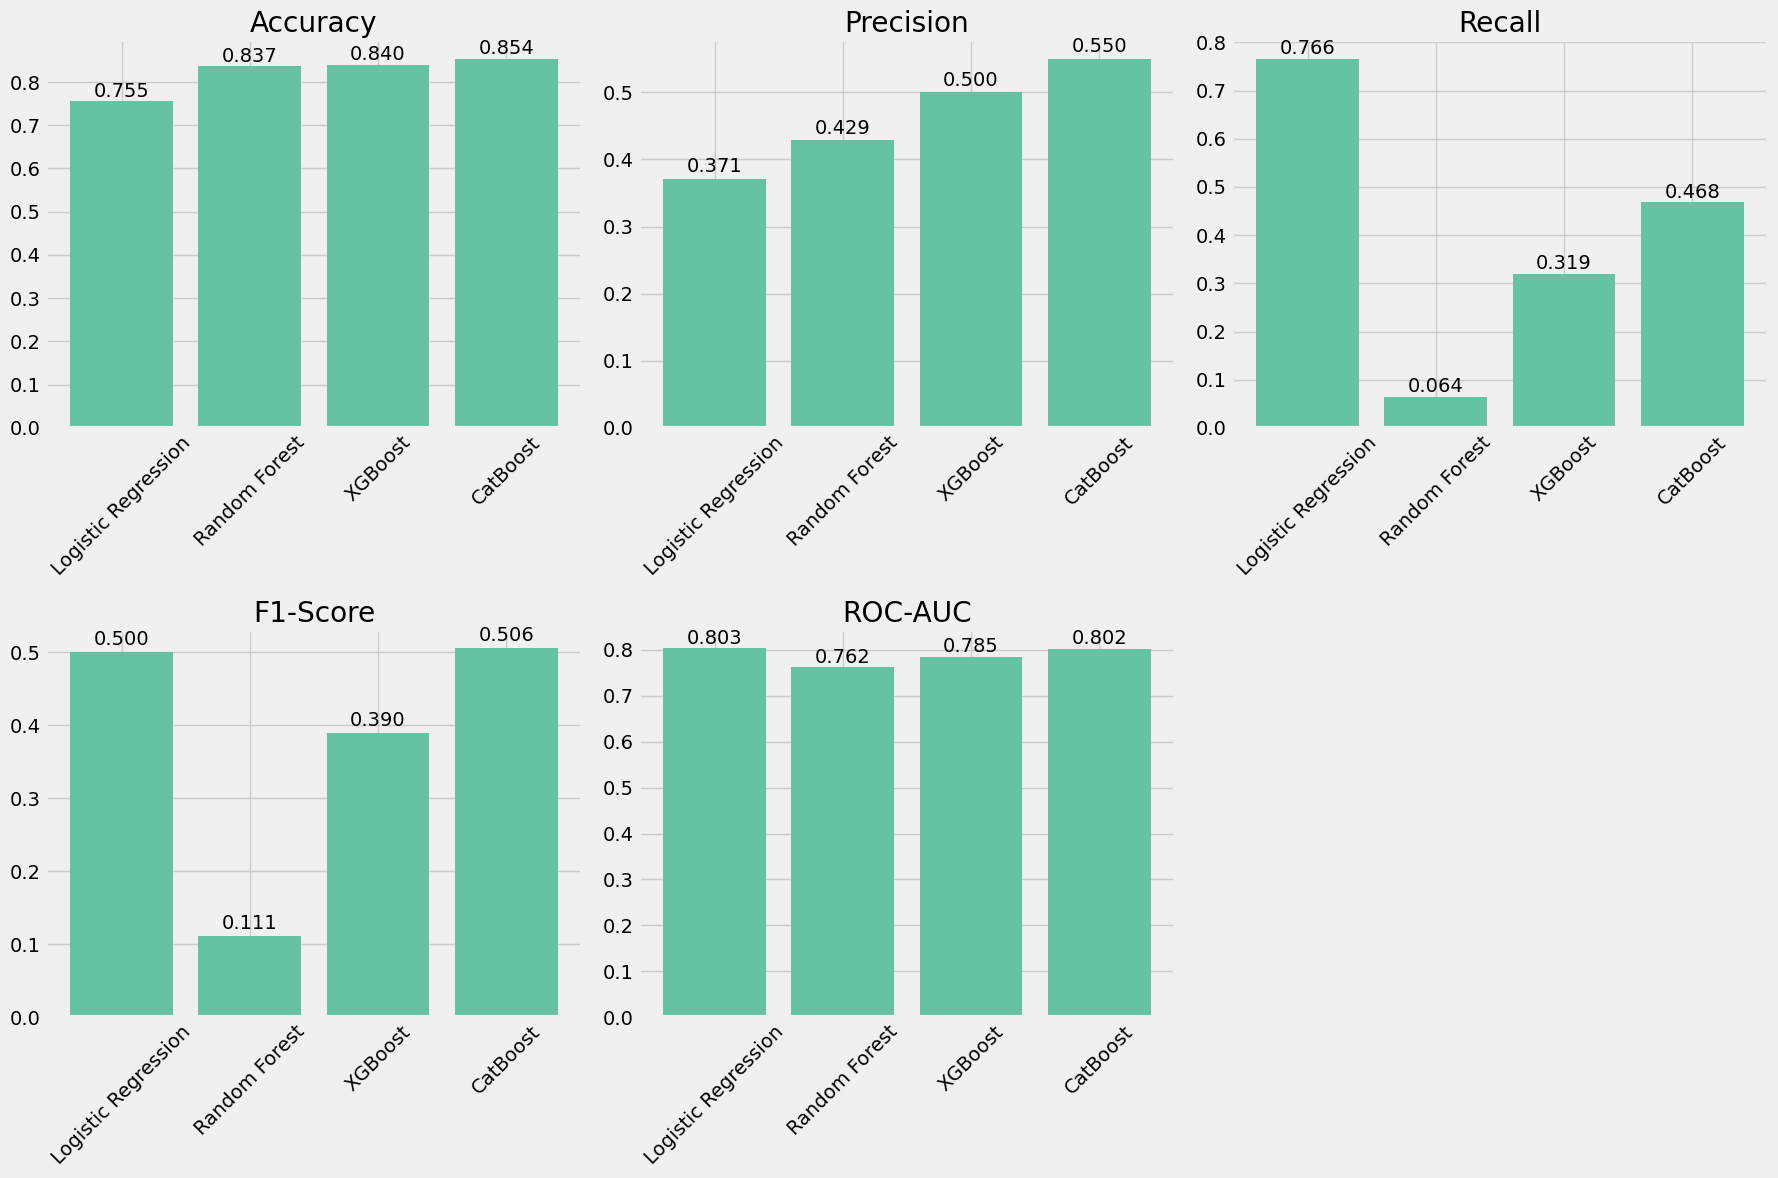

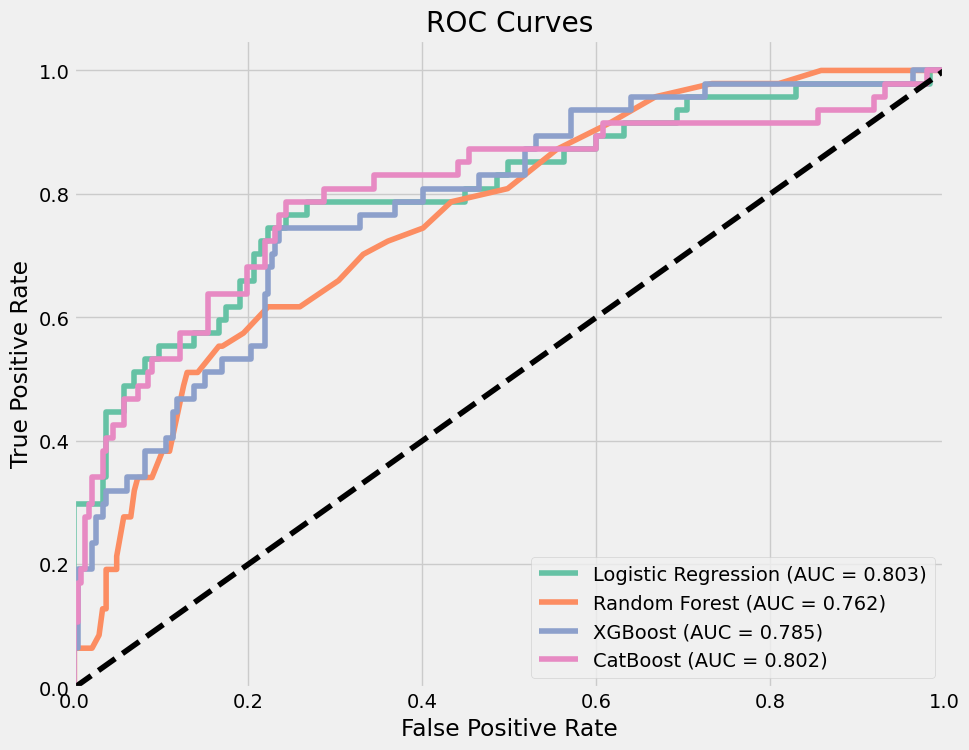

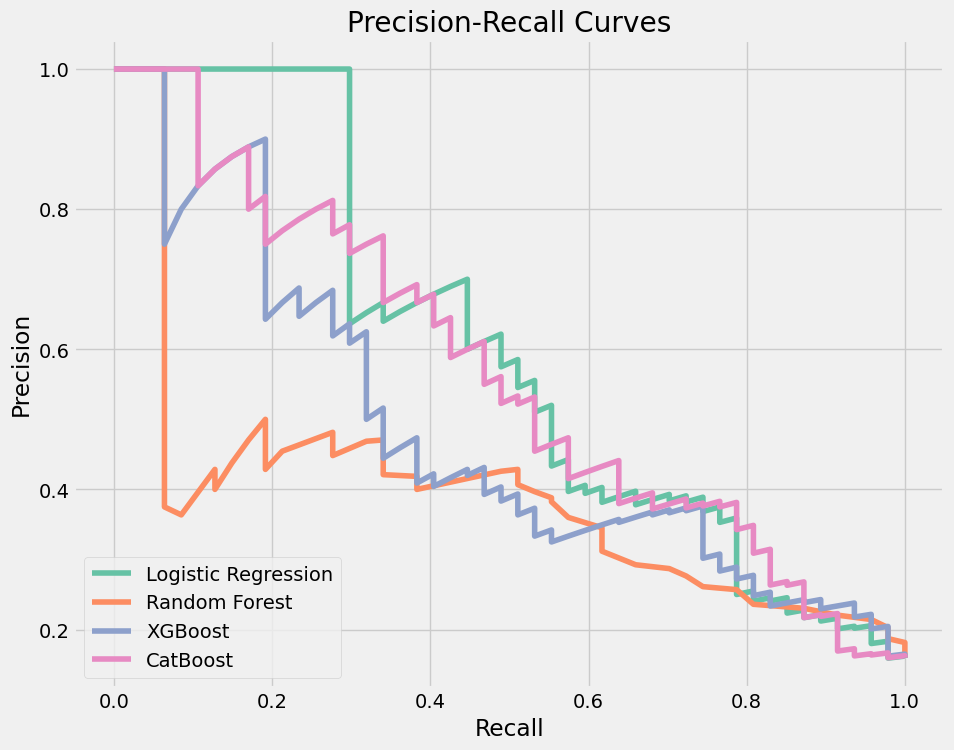

Best model: CatBoost


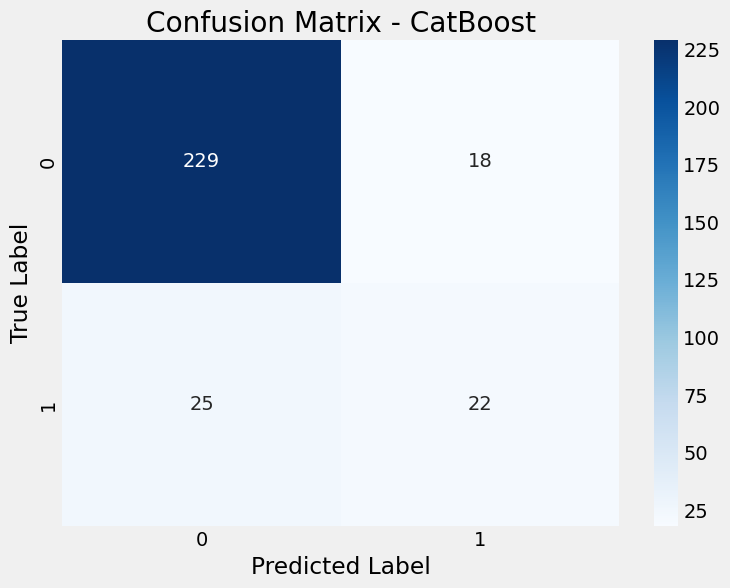


Classification Report - CatBoost:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       247
           1       0.55      0.47      0.51        47

    accuracy                           0.85       294
   macro avg       0.73      0.70      0.71       294
weighted avg       0.85      0.85      0.85       294



In [8]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
    values = [results[m][key] for m in results]
    axes[i].bar(results.keys(), values)
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    plt.plot(recall, precision, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()

best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

print(f"Best model: {best_model_name}")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best))